In [70]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import re
import os
import numpy as np
import matplotlib.pyplot as plt

In [71]:
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"
temporary = "temporary_data\\"
final_scripts = "final_scripts\\"
regression = "regression\\"
normalized_dataframes = "normalized_dataframes\\"
normalized_regression_boards = "normalized_regression_boards\\"
network = "network\\"
network_boards = "network_boards\\"


college_matching = "college_matching\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{final_scripts}{regression}{normalized_dataframes}"
temporary_data_path = f"{absolute_path}{temporary}"
college_matching_path = f"{absolute_path}{college_matching}"

# Valid Years
years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

diversity_statistics_path = f"{altered_dataframe_path}diversity_statistics.csv"
carnegie_map = pd.read_csv(f"{college_matching_path}carnegie_map_openalex.csv")
classification_map = pd.read_csv(f"{college_matching_path}cc_download.csv")
state_path = f"{temporary_data_path}state_systems_validated.csv"   
billionaires_path = f"{temporary_data_path}billionaires_1997_2015.csv"

In [72]:
board_statistics_path = f"{absolute_path}{final_scripts}{regression}regression_stats\\regression_university_board_statistics.csv"
board_statistics_df = pd.read_csv(board_statistics_path)
board_statistics_df["control"] = board_statistics_df["control"].fillna("Unknown")
board_statistics_df["control"] = board_statistics_df["control"].replace("", "Unknown")
board_statistics_df["region"] = board_statistics_df["region"].fillna("Unknown")
board_statistics_df["region"] = board_statistics_df["region"].replace("", "Unknown")
board_statistics_df["duplicate"] = board_statistics_df.duplicated(subset=["Institution", "Year"], keep=False)

# Now, drop duplicates based on the "Institution" and "Year" columns, keeping only the first occurrence.
board_statistics_df = board_statistics_df.drop_duplicates(subset=["Institution", "Year"], keep="first")
def lookup_female_president(row, year):
    """
    Look up the 'female_president' boolean from board_statistics_df for a given row and year.
    
    The function first filters board_statistics_df by the specified year, then attempts to
    match either on 'AffiliationId' (using row['AffiliationId']) or on 'Institution' (using row['Id']).
    It returns the boolean value from the 'female_president' column.
    
    Raises:
        ValueError: If no matching record is found.
    """
    filtered_df = board_statistics_df[board_statistics_df['Year'] == int(year)]
    if row["Id"] in filtered_df["Institution"].values:
        matching_row = filtered_df[filtered_df["Institution"] == row["Id"]].iloc[0]
        if matching_row['female_president'] == True:
            return True
        else:
            return False
    elif row["AffiliationId"] in filtered_df["AffiliationId"].values:
        matching_row = filtered_df[filtered_df["AffiliationId"] == row["AffiliationId"]].iloc[0]
        if matching_row['female_president'] == True:
            return True
        else:
            return False
    return "Unknown"

def lookup_column(row, column_name):
    matching_rows = board_statistics_df[ board_statistics_df['AffiliationId'] == row['AffiliationId'] ]
    if not matching_rows.empty:
        return matching_rows[column_name].mode()[0]
    matching_rows = board_statistics_df[ board_statistics_df['Institution'] == row['Id'] ]
    if not matching_rows.empty:
        return matching_rows[column_name].mode()[0]
    return 'unknown'


In [73]:
#time invariant dfs
affiliation_df = pd.read_csv(f"{absolute_path}{final_scripts}{regression}regression_stats\\affiliation_systems.csv")
original_affiliation_df  = pd.read_csv(f"{absolute_path}{final_scripts}{regression}regression_stats\\affiliation_original.csv")

#create a dictionary mapping state system -> institutions within the system
affiliation_dict = affiliation_df.groupby("StateSystem")["AffiliationId"].apply(list).to_dict()

affiliation_inverted = {
    aff_id: state_system
    for state_system, aff_ids in affiliation_dict.items()
    for aff_id in aff_ids
}

matched_df = original_affiliation_df[original_affiliation_df["FullName"].isin(affiliation_dict.keys())].copy()

matched_df["StateSystem"] = matched_df["FullName"]

mapping_df = matched_df[["StateSystem", "AffiliationId"]]

mapping_df = mapping_df.drop_duplicates()

system_id_map = {}
nan_id_map = {}

for _, row in mapping_df.iterrows():
    state_system = row["StateSystem"]
    board_aff_id = row["AffiliationId"]
    if pd.isna(board_aff_id):
        nan_id_map[state_system] = affiliation_dict.get(state_system, [])
    else:
        system_id_map[board_aff_id] = affiliation_dict.get(state_system, [])

# Display the resulting dictionary
print(system_id_map)
print(nan_id_map)

# Convert system_id_map values to a list of sets.
# Each value is first cast to int then to str.
system_lists = []
for vals in system_id_map.values():
    sys_set = set(str(int(float(x))).strip() for x in vals if pd.notna(x))
    if sys_set and sys_set not in system_lists:
        system_lists.append(sys_set)
print(system_lists)

print(mapping_df.head)

{127339247.0: [184813773, 67328108, 67328108, 142934699, 142934699, 142934699, 59897056, 59897056, 43369023, 43369023, 26538001, 71838634], 174216632.0: [125687163, 125687163, 125687163], 4210131357.0: [92446798, 92446798, 92446798, 92446798], 4210165361.0: [120156002, 106969075, 155093810], 2801365651.0: [189590672, 146416000, 39587148], 4210141039.0: [61937129, 99041443, 368840534, 44854399], 4210127926.0: [57328836, 24571045, 24571045], 29957033.0: [200885203, 161171246, 161171246], 1327163397.0: [392282, 392282, 392282, 392282, 123946342, 123946342, 123946342, 123946342, 63190737, 63190737, 63190737, 63190737, 59553526, 59553526, 59553526, 59553526, 59553526], 2801649442.0: [8248082, 63772739, 19700959, 106165777, 33213144, 11874761, 2613432], 173268674.0: [75063564, 91045830, 91045830, 91045830, 206651237, 206651237, 96749437, 96749437, 164185940, 164185940, 181414168, 181414168], 2801273398.0: [191429286, 13511017, 13511017, 13511017, 13511017], 4210088475.0: [12315562, 926076166

In [74]:
'''
Collapse the state boards:
    for each state system, union them together, and make the node id the affiliation id of the system, and then when we export the stats for the regression, we can use 
    the mapping to fill for all the institutions
'''

for year in years:
    print(f"Processing year: {year}")
    board_path = os.path.join(absolute_path, f"{final_scripts}{regression}{normalized_regression_boards}{year}_boards_normalized_regression.csv")
    double_board_path = os.path.join(absolute_path, f"{final_scripts}{regression}{normalized_regression_boards}{year}_double_boards_normalized_regression.csv")
    board_df = pd.read_csv(board_path)
    double_board_df = pd.read_csv(double_board_path)
    
    updated_board_df = board_df.copy()
    updated_double_board_df = double_board_df.copy()
    
    # Process nan_id_map for board_df
    for system_name, school_ids in nan_id_map.items():
        school_ids_float64 = [np.float64(sid) for sid in school_ids]
        system_rows = board_df[board_df['AffiliationId'].isin(school_ids_float64)]
        if not system_rows.empty:
            unioned_rows = system_rows.copy()
            unioned_rows['Institution'] = system_name
            updated_board_df = updated_board_df[~updated_board_df['AffiliationId'].isin(school_ids)]
            updated_board_df = pd.concat([updated_board_df, unioned_rows], ignore_index=True)
            print(f"Collapsed nan system '{system_name}' in board_df: replaced {system_rows.shape[0]} rows with unioned board.")
    
    # Process nan_id_map for double_board_df
    for system_name, school_ids in nan_id_map.items():
        school_ids_float64 = [np.float64(sid) for sid in school_ids]
        system_rows = double_board_df[double_board_df['AffiliationId'].isin(school_ids_float64)]
        if not system_rows.empty:
            unioned_rows = system_rows.copy()
            unioned_rows['Institution'] = system_name
            updated_double_board_df = updated_double_board_df[~updated_double_board_df['AffiliationId'].isin(school_ids)]
            updated_double_board_df = pd.concat([updated_double_board_df, unioned_rows], ignore_index=True)
            print(f"Collapsed nan system '{system_name}' in double_board_df: replaced {system_rows.shape[0]} rows with unioned board.")
    
    # Process system_id_map for board_df
    for state_system_aff, school_ids in system_id_map.items():
        system_rows = board_df[board_df['AffiliationId'].isin(school_ids)]
        if not system_rows.empty:
            unioned_rows = system_rows.copy()
            unioned_rows['AffiliationId'] = state_system_aff
            match = mapping_df.loc[mapping_df['AffiliationId'] == state_system_aff, 'StateSystem']
            if not match.empty:
                system_name = match.iloc[0]
            else:
                system_name = "Unknown System"
            unioned_rows['Institution'] = system_name
            updated_board_df = updated_board_df[~updated_board_df['AffiliationId'].isin(school_ids)]
            updated_board_df = pd.concat([updated_board_df, unioned_rows], ignore_index=True)
            # print(f"Collapsed system {state_system_aff} ({system_name}) in board_df: replaced {system_rows.shape[0]} rows with unioned board.")
    
    # Process system_id_map for double_board_df
    for state_system_aff, school_ids in system_id_map.items():
        system_rows = double_board_df[double_board_df['AffiliationId'].isin(school_ids)]
        if not system_rows.empty:
            unioned_rows = system_rows.copy()
            unioned_rows['AffiliationId'] = state_system_aff
            match = mapping_df.loc[mapping_df['AffiliationId'] == state_system_aff, 'StateSystem']
            if not match.empty:
                system_name = match.iloc[0]
            else:
                system_name = "Unknown System"
            unioned_rows['Institution'] = system_name
            updated_double_board_df = updated_double_board_df[~updated_double_board_df['AffiliationId'].isin(school_ids)]
            updated_double_board_df = pd.concat([updated_double_board_df, unioned_rows], ignore_index=True)
            # print(f"Collapsed system {state_system_aff} ({system_name}) in double_board_df: replaced {system_rows.shape[0]} rows with unioned board.")
    
    updated_board_df.sort_values(by=['Institution'], inplace=True)
    updated_board_df.drop_duplicates(subset=['Institution', 'Name'], inplace=True)
    updated_double_board_df.sort_values(by=['Institution'], inplace=True)
    updated_double_board_df.drop_duplicates(subset=['Institution', 'Name'], inplace=True)
    
    board_path = os.path.join(absolute_path, f"{final_scripts}{network}{network_boards}{year}_network_boards.csv")
    double_board_path = os.path.join(absolute_path, f"{final_scripts}{network}{network_boards}{year}_network_double_boards.csv")
    updated_board_df.to_csv(board_path, index=False)
    updated_double_board_df.to_csv(double_board_path, index=False)


Processing year: 1999
Collapsed nan system 'Arizona Board of Regents' in board_df: replaced 35 rows with unioned board.
Collapsed nan system 'Oklahoma State System of Higher Education' in board_df: replaced 35 rows with unioned board.
Collapsed nan system 'Tennessee Board of Regents' in board_df: replaced 64 rows with unioned board.
Collapsed nan system 'Tennessee Board of Regents' in double_board_df: replaced 130 rows with unioned board.
Processing year: 2000
Collapsed nan system 'Arizona Board of Regents' in board_df: replaced 35 rows with unioned board.
Collapsed nan system 'Oklahoma State System of Higher Education' in board_df: replaced 32 rows with unioned board.
Collapsed nan system 'Tennessee Board of Regents' in board_df: replaced 100 rows with unioned board.
Collapsed nan system 'Tennessee Board of Regents' in double_board_df: replaced 44 rows with unioned board.
Processing year: 2005
Collapsed nan system 'Arizona Board of Regents' in board_df: replaced 30 rows with unioned b

In [75]:
import os
import re
import pandas as pd
import networkx as nx
import numpy as np
from collections import defaultdict

substrings_to_remove = [
    "Rev.", "SJ", "Sister", "Brother", "Father", "OP", "The Very",
    "Sr.", "O.P.", "Very Rev.", "Br.", "Dr.", "Md.", "S.J.", "Very Rev",
    "M.D.", "O.P", "S.J", "J.R", "Jr.", "Jr ", "III"
]

def clean_name(raw_name: str) -> str:
    for title in substrings_to_remove:
        raw_name = re.sub(r'\b' + re.escape(title.strip()) + r'\b', '', raw_name, flags=re.IGNORECASE)
    raw_name = re.sub(r'[^\w\s]', '', raw_name)
    return " ".join(raw_name.split()).title()

# Global edge counter and yearly data dictionaries.
edge_id_counter = 1
yearly_graphs = {}
yearly_nodes_dfs = {}
yearly_edges_dfs = {}
yearly_interlock_counts = []
yearly_avg_path_lengths = []
yearly_university_counts = []
yearly_density = []
yearly_shortest_path_lengths = []
yearly_global_clustering = []
yearly_num_components = []

for year in years:
    print(f"Processing year: {year}")
    board_path = os.path.join(absolute_path, f"{final_scripts}{network}{network_boards}{year}_network_boards.csv")
    double_board_path = os.path.join(absolute_path, f"{final_scripts}{network}{network_boards}{year}_network_double_boards.csv")
    board_df = pd.read_csv(board_path)
    double_board_df = pd.read_csv(double_board_path)

    combined_df = pd.concat([board_df, double_board_df], ignore_index=True)
    board_sizes = combined_df.groupby("Institution").size().to_dict()
    
    board_member_dict = defaultdict(set)
    edge_accum = {}
    # Initialize with NaN for missing affiliation IDs.
    year_nodes_dict = defaultdict(lambda: {'Interlock_Count': 0, 'AffiliationId': np.nan})
    context_dict = {'total_interlocks': 0, 'edge_id_counter': edge_id_counter}
    created_interlocks = defaultdict(set)
    
    for _, row in combined_df.iterrows():
        # Skip rows with "vacant"
        if "vacant" in str(row["Name"]).lower():
            continue
        name = clean_name(row["Name"])
        institution = row["Institution"]
        # Convert affiliation_id: if not null, convert to string; otherwise, assign np.nan.
        if pd.notnull(row["AffiliationId"]):
            try:
                affiliation_id = str(int(float(row["AffiliationId"]))).strip()
            except Exception:
                affiliation_id = str(row["AffiliationId"]).strip()
        else:
            affiliation_id = np.nan

        for prev_institution in board_member_dict[name]:
            if prev_institution == institution:
                continue
            pair = tuple(sorted([prev_institution, institution]))
            if pair in created_interlocks[name]:
                continue
            created_interlocks[name].add(pair)
            
            # Get affiliation IDs for both institutions.
            id1 = None
            if pd.notnull(year_nodes_dict.get(prev_institution, {}).get('AffiliationId')):
                try:
                    id1 = str(int(float(year_nodes_dict[prev_institution]['AffiliationId']))).strip()
                except Exception:
                    id1 = str(year_nodes_dict[prev_institution]['AffiliationId']).strip()
            id2 = None
            if pd.notnull(affiliation_id):
                id2 = affiliation_id
            
            same_system = False
            if id1 and id2:
                for sys_set in system_lists:
                    if id1 in sys_set and id2 in sys_set:
                        same_system = True
                        break
            if same_system:
                continue
            # Count this interlock: each shared board member contributes 1.
            w = 1
            if pair in edge_accum:
                edge_accum[pair]['Weight'] += w
            else:
                edge_id = f"e_{year}_{context_dict['edge_id_counter']}"
                context_dict['edge_id_counter'] += 1
                edge_accum[pair] = {
                    'Id': edge_id,
                    'Source': pair[0],
                    'Target': pair[1],
                    'Type': 'Undirected',
                    'Weight': w,
                    'Year': year
                }
            context_dict['total_interlocks'] += 1
            year_nodes_dict[prev_institution]['Interlock_Count'] += w
            year_nodes_dict[institution]['Interlock_Count'] += w
        board_member_dict[name].add(institution)
        # Always update the affiliation id if none is stored yet.
        if pd.isnull(year_nodes_dict[institution]['AffiliationId']):
            year_nodes_dict[institution]['AffiliationId'] = affiliation_id

    total_interlocks = context_dict['total_interlocks']
    edge_id_counter = context_dict['edge_id_counter']
    
    # Recalculate each edge's weight as: shared / (board_size(inst1) + board_size(inst2))
    for pair, edge in edge_accum.items():
        inst1, inst2 = pair
        size1 = board_sizes.get(inst1, 0)
        size2 = board_sizes.get(inst2, 0)
        denom = size1 + size2 if (size1 + size2) > 0 else 1
        edge['Weight'] = edge['Weight'] / denom

    # Build nodes DataFrame (include all institutions, even those with zero interlocks).
    nodes_data = []
    for inst, data in year_nodes_dict.items():
        nodes_data.append({
            'Id': inst,
            'Label': inst,
            'Interlock_Count': data['Interlock_Count'],
            'AffiliationId': data['AffiliationId'],
            'Board_Size': board_sizes.get(inst, 0)
        })
    nodes_df = pd.DataFrame(nodes_data)
    
    if edge_accum:
        edges_df = pd.DataFrame(list(edge_accum.values()))
        edges_df = edges_df[['Id', 'Source', 'Target', 'Type', 'Weight', 'Year']]
    else:
        edges_df = pd.DataFrame(columns=['Id', 'Source', 'Target', 'Type', 'Weight', 'Year'])
    
    out_nodes_path = os.path.join(absolute_path, f"{final_scripts}{network}network_interlocks\\{year}_network_interlock_nodes.csv")
    out_edges_path = os.path.join(absolute_path, f"{final_scripts}{network}network_interlocks\\{year}_network_interlock_edges.csv")
    nodes_df.to_csv(out_nodes_path, index=False)
    edges_df.to_csv(out_edges_path, index=False)
    
    print(f"Year {year} interlock nodes saved to: {out_nodes_path}")
    print(f"Year {year} interlock edges saved to: {out_edges_path}")
    
    # Build weighted graph and compute summary metrics using only nodes with degree > 0.
    G = nx.Graph()
    # Filter nodes: only include those with nonzero Interlock_Count
    nodes_for_graph = nodes_df[nodes_df["Interlock_Count"] > 0]
    for _, node_row in nodes_for_graph.iterrows():
        G.add_node(node_row["Id"],
                   AffiliationId=node_row["AffiliationId"],
                   Label=node_row["Label"],
                   Interlock_Count=node_row["Interlock_Count"])
    valid_nodes = set(G.nodes())
    for _, edge_row in edges_df.iterrows():
        if edge_row["Source"] in valid_nodes and edge_row["Target"] in valid_nodes:
            G.add_edge(edge_row["Source"], edge_row["Target"], weight=edge_row.get("Weight", 1))
    
    yearly_graphs[year] = G
    yearly_nodes_dfs[year] = nodes_df  # full nodes (for CSV)
    yearly_edges_dfs[year] = edges_df
    num_interlocked_institutions = len(G.nodes())  # all nodes in G have degree > 0
    dens = nx.density(G)
    
    # Build an unweighted version of G for average path length calculation.
    G_unweighted = nx.Graph()
    G_unweighted.add_nodes_from(G.nodes(data=True))
    for u, v in G.edges():
        G_unweighted.add_edge(u, v, weight=1)
    if nx.is_connected(G_unweighted):
        avg_path_unweighted = nx.average_shortest_path_length(G_unweighted)
    else:
        if G_unweighted.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G_unweighted), key=len)
            subG_unweighted = G_unweighted.subgraph(largest_cc)
            avg_path_unweighted = nx.average_shortest_path_length(subG_unweighted)
        else:
            avg_path_unweighted = float('nan')
    if nx.is_connected(G):
        avg_path_weighted = nx.average_shortest_path_length(G, weight="weight")
    else:
        if G.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G), key=len)
            subG = G.subgraph(largest_cc)
            avg_path_weighted = nx.average_shortest_path_length(subG, weight="weight")
        else:
            avg_path_weighted = float('nan')
    
    yearly_interlock_counts.append((int(year), total_interlocks))
    yearly_university_counts.append((int(year), num_interlocked_institutions))
    yearly_density.append((int(year), dens))
    yearly_avg_path_lengths.append((int(year), avg_path_unweighted))
    yearly_shortest_path_lengths.append((int(year), avg_path_unweighted, avg_path_weighted))
    global_clust = nx.transitivity(G)
    num_components = nx.number_connected_components(G)
    yearly_global_clustering.append((int(year), global_clust))
    yearly_num_components.append((int(year), num_components))

# Global Nodes and Edges DataFrames.
global_nodes_df = pd.concat(list(yearly_nodes_dfs.values()), ignore_index=True)
global_nodes_df = global_nodes_df.drop_duplicates(subset=["Id"])
global_edges_df = pd.concat(list(yearly_edges_dfs.values()), ignore_index=True)
global_nodes_path = os.path.join(absolute_path, f"{final_scripts}{network}network_interlocks\\global_network_interlock_nodes.csv")
global_edges_path = os.path.join(absolute_path, f"{final_scripts}{network}network_interlocks\\global_network_interlock_edges.csv")
global_nodes_df.to_csv(global_nodes_path, index=False)
global_edges_df.to_csv(global_edges_path, index=False)
print(f"Global nodes CSV written to: {global_nodes_path}")
print(f"Global edges CSV written to: {global_edges_path}")


Processing year: 1999
Year 1999 interlock nodes saved to: C:\Users\tykun\\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\network\network_interlocks\1999_network_interlock_nodes.csv
Year 1999 interlock edges saved to: C:\Users\tykun\\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\network\network_interlocks\1999_network_interlock_edges.csv
Processing year: 2000
Year 2000 interlock nodes saved to: C:\Users\tykun\\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\network\network_interlocks\2000_network_interlock_nodes.csv
Year 2000 interlock edges saved to: C:\Users\tykun\\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\network\network_interlocks\2000_network_interlock_edges.csv
Processing year: 2005
Year 2005 interlock nodes saved to: C:\Users\tykun\\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_sc

In [76]:
# # =============================================================================
# # Add Network Statistics into board_statistics_df
# # =============================================================================

# # --- Compute centrality measures for each year's graph and update the yearly nodes DataFrames ---
# for year in years:
#     # Retrieve the graph and corresponding nodes DataFrame for the year.
#     G = yearly_graphs[year]
#     nodes_df = yearly_nodes_dfs[year].copy()
    
#     # Compute centrality measures on G.
#     betweenness = nx.betweenness_centrality(G, weight="weight")
#     closeness = nx.closeness_centrality(G)
#     eigenvector = nx.eigenvector_centrality(G, max_iter=5000, weight="weight")
#     degree_dict = dict(G.degree())
#     clustering = nx.clustering(G, weight="weight")
    
#     # Add the centrality measures as new columns.
#     nodes_df["betweenness"] = nodes_df["Id"].map(betweenness)
#     nodes_df["closeness"] = nodes_df["Id"].map(closeness)
#     nodes_df["eigenvector"] = nodes_df["Id"].map(eigenvector)
#     nodes_df["degree"] = nodes_df["Id"].map(degree_dict)
#     nodes_df["clustering"] = nodes_df["Id"].map(clustering)
    
#     # Make sure there is a 'Year' column (as string) in each nodes DataFrame.
#     if 'Year' not in nodes_df.columns:
#         nodes_df['Year'] = str(year)
#     else:
#         nodes_df['Year'] = nodes_df['Year'].astype(str)
    
#     # Update the yearly nodes DataFrame.
#     yearly_nodes_dfs[year] = nodes_df

# # Ensure 'Year' and 'AffiliationId' columns are strings.
# global_nodes_df = pd.concat(list(yearly_nodes_dfs.values()), ignore_index=True)
# global_nodes_df['Year'] = global_nodes_df['Year'].astype(str)
# global_nodes_df['AffiliationId'] = global_nodes_df['AffiliationId'].astype(str)

# board_statistics_df['Year'] = board_statistics_df['Year'].astype(str)
# board_statistics_df['AffiliationId'] = board_statistics_df['AffiliationId'].astype(str)

# # Merge network statistics from global_nodes_df into board_statistics_df.
# merged_df = board_statistics_df.merge(
#     global_nodes_df[["Year", "AffiliationId", "betweenness", "closeness", "eigenvector", "degree", "clustering"]],
#     on=["Year", "AffiliationId"],
#     how="left",
#     suffixes=("", "_new")
# )

# for col in ["betweenness", "closeness", "eigenvector", "degree", "clustering"]:
#     if f"{col}_new" in merged_df.columns:
#         merged_df[col] = merged_df[f"{col}_new"]
#         merged_df.drop(columns=[f"{col}_new"], inplace=True)

# centrality_columns = ["betweenness", "closeness", "eigenvector", "degree", "clustering"]
# merged_df[centrality_columns] = merged_df[centrality_columns].fillna(0)

# updated_stats_path = f"{absolute_path}{final_scripts}{regression}regression_stats\\regression_university_board_statistics.csv"
# merged_df.to_csv(updated_stats_path, index=False)
# print(f"Updated board_statistics_df with network statistics written to: {updated_stats_path}")


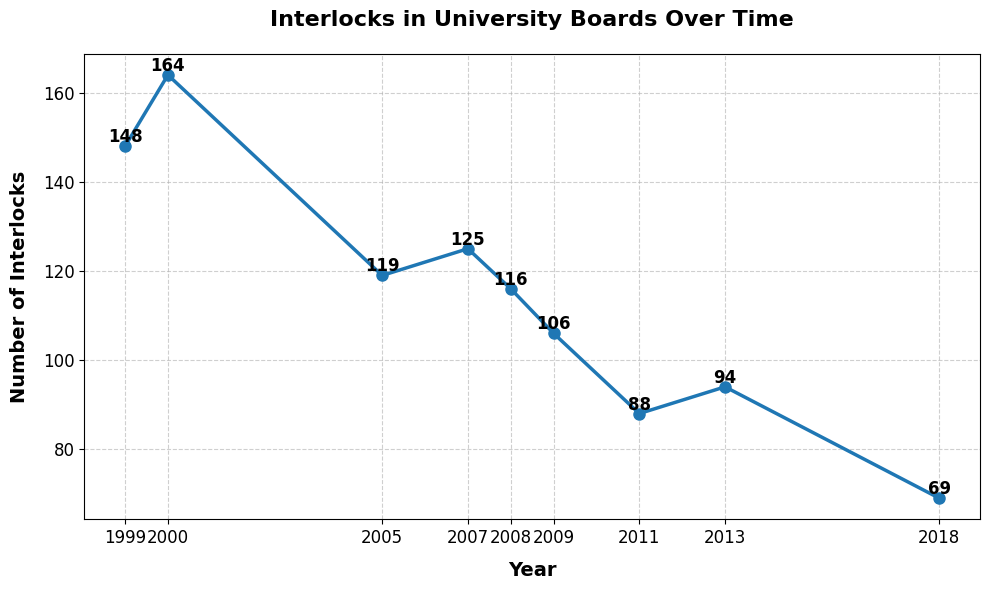

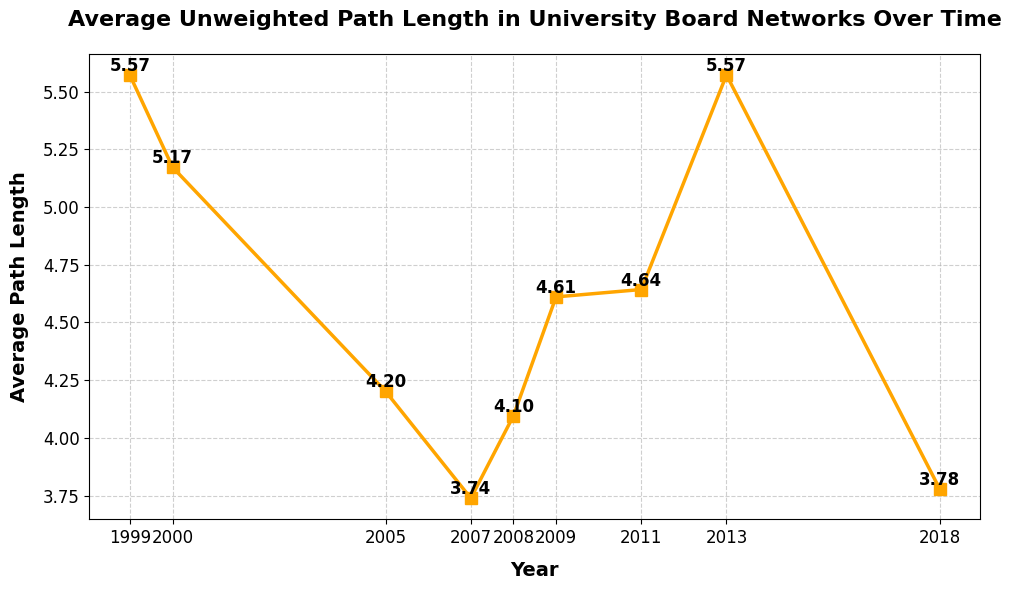

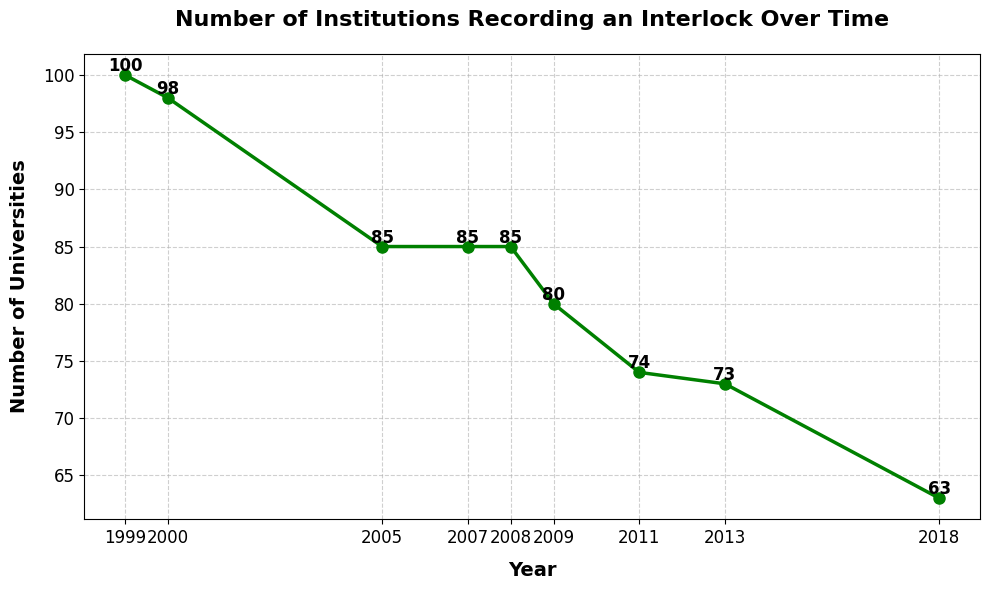

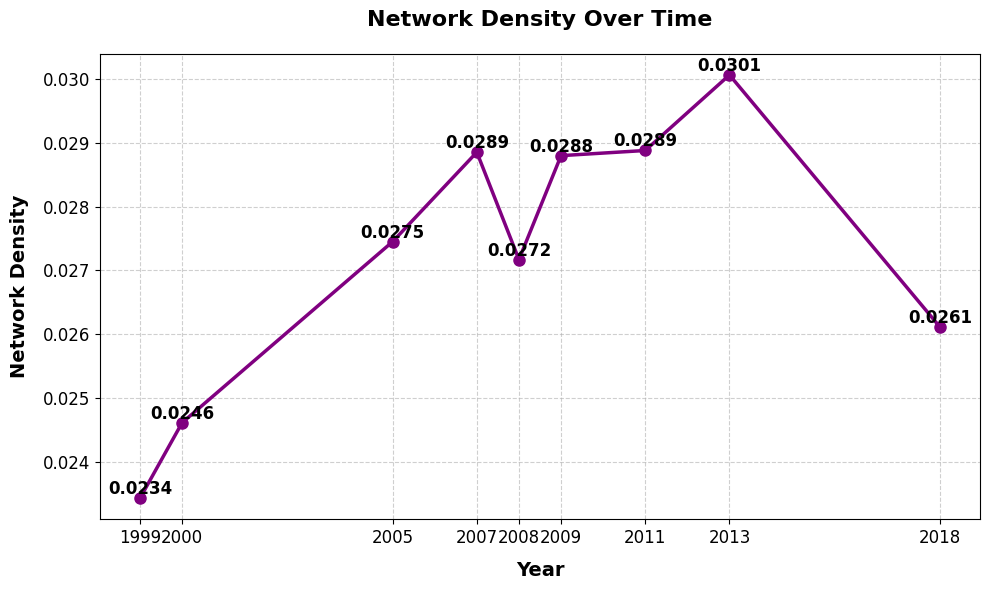

C:\Users\tykun\AppData\Local\Temp\ipykernel_9780\409785773.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


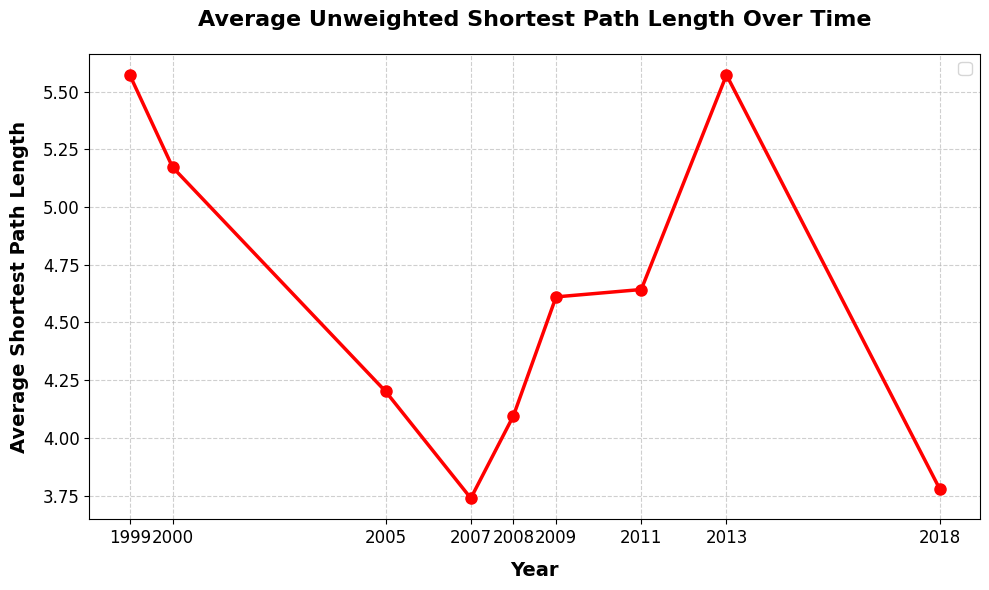

C:\Users\tykun\AppData\Local\Temp\ipykernel_9780\409785773.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


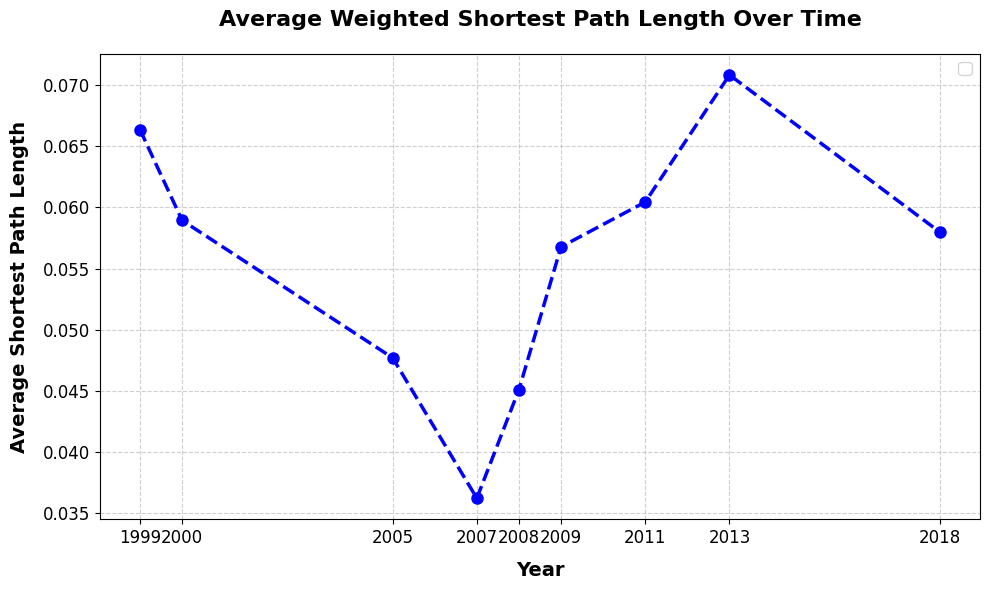

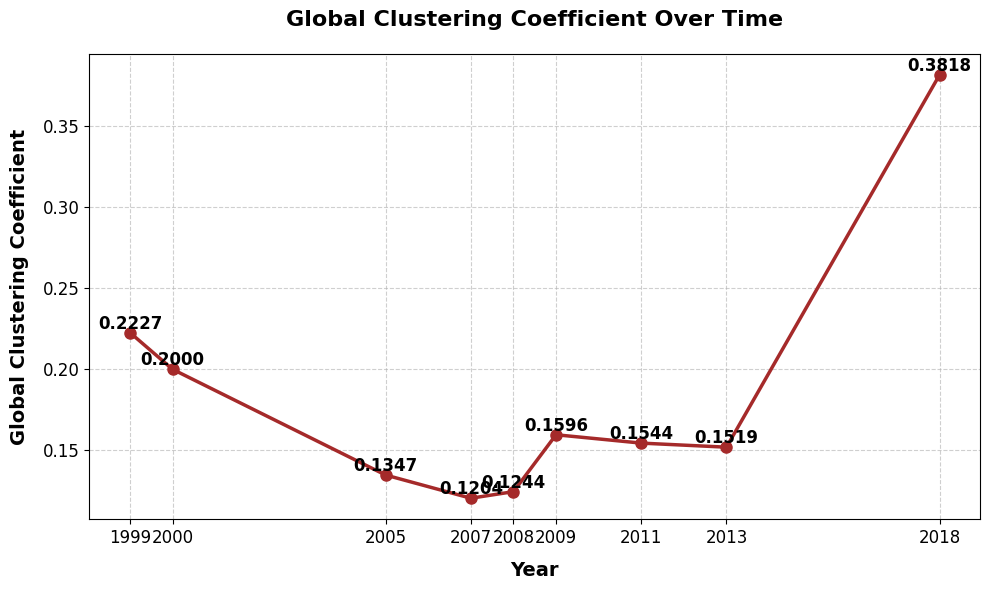

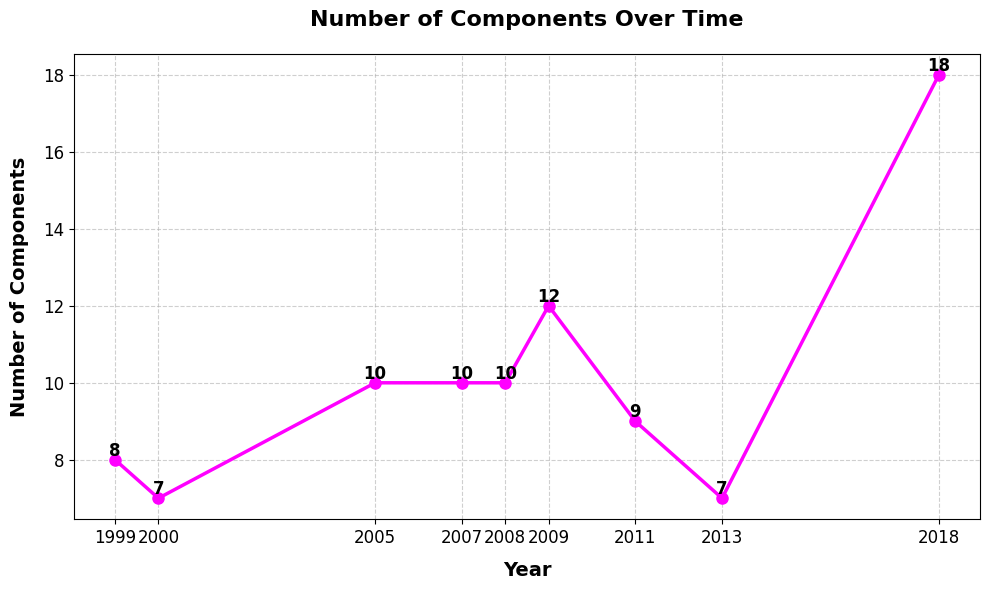

In [77]:
# 1) Plot Total Interlocks Over Time
df_interlocks = pd.DataFrame(yearly_interlock_counts, columns=['Year', 'TotalInterlocks'])
df_interlocks = pd.DataFrame(yearly_interlock_counts, columns=['Year', 'TotalInterlocks'])
df_interlocks.sort_values('Year', inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(df_interlocks['Year'], df_interlocks['TotalInterlocks'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='#1f77b4')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Interlocks', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Interlocks in University Boards Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_interlocks['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_interlocks['Year'], df_interlocks['TotalInterlocks']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 2) Plot Average Path Length Over Time (Unweighted)
df_avg_path = pd.DataFrame(yearly_avg_path_lengths, columns=['Year', 'AvgPathLength'])
df_avg_path.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_avg_path['Year'], df_avg_path['AvgPathLength'], marker='s', linestyle='-', linewidth=2.5, markersize=8, color='orange')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Unweighted Path Length in University Board Networks Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_avg_path['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_avg_path['Year'], df_avg_path['AvgPathLength']):
    plt.text(x, y, f'{y:.2f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 3) Plot Number of Universities Over Time (institutions that recorded at least one interlock)
df_universities = pd.DataFrame(yearly_university_counts, columns=['Year', 'NumUniversities'])
df_universities.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_universities['Year'], df_universities['NumUniversities'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='green')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Universities', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Number of Institutions Recording an Interlock Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_universities['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_universities['Year'], df_universities['NumUniversities']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4) Plot Network Density Over Time
df_density = pd.DataFrame(yearly_density, columns=['Year', 'Density'])
df_density.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_density['Year'], df_density['Density'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='purple')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Network Density', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Network Density Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_density['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_density['Year'], df_density['Density']):
    plt.text(x, y, f'{y:.4f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 5) Plot Average Shortest Path Length Over Time (Separate Unweighted & Weighted)
df_shortest_paths = pd.DataFrame(yearly_shortest_path_lengths, columns=['Year', 'AvgPathLength', 'AvgWeightedPathLength'])
df_shortest_paths.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_shortest_paths['Year'], df_shortest_paths['AvgPathLength'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='red')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Shortest Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Unweighted Shortest Path Length Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_shortest_paths['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_shortest_paths['Year'], df_shortest_paths['AvgWeightedPathLength'], marker='o', linestyle='--', linewidth=2.5, markersize=8, color='blue')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Shortest Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Weighted Shortest Path Length Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_shortest_paths['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 6) Plot Global Clustering Coefficient Over Time
df_global_clustering = pd.DataFrame(yearly_global_clustering, columns=['Year', 'GlobalClustering'])
df_global_clustering.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_global_clustering['Year'], df_global_clustering['GlobalClustering'], marker='o', linestyle='-', 
         linewidth=2.5, markersize=8, color='brown')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Global Clustering Coefficient', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Global Clustering Coefficient Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_global_clustering['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_global_clustering['Year'], df_global_clustering['GlobalClustering']):
    plt.text(x, y, f'{y:.4f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 7) Plot Number of Components Over Time
df_components = pd.DataFrame(yearly_num_components, columns=['Year', 'NumComponents'])
df_components.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_components['Year'], df_components['NumComponents'], marker='o', linestyle='-', 
         linewidth=2.5, markersize=8, color='magenta')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Components', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Number of Components Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_components['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_components['Year'], df_components['NumComponents']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()
